In [1]:
import numpy as np
import skimage.transform
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import os
import glob
import PIL.ImageDraw
import PIL.Image

%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest' 
matplotlib.rcParams['image.cmap'] = 'gray'

Populating the interactive namespace from numpy and matplotlib


In [2]:
telap_dir = os.path.normpath('/astro/opticslab1/SCDA/Apertures/JPL/wfirst')
os.listdir(telap_dir)

['AFTA_CGI_C5_Pupil_onax_1000px.fits', '._AFTA_CGI_C5_Pupil_onax_1000px.fits']

In [36]:
new_telap_dir = os.path.normpath("/astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/TelAp/")
#new_telap_dir = os.path.expanduser("~/Box Sync/scda/InputMasks_wfirst/TelAp")
if not os.path.exists(new_telap_dir):
    os.mkdir(new_telap_dir)
    print("created {:s} for binned aperture arrays".format(new_telap_dir))
else:
    print("Destination {:s} already exists".format(new_telap_dir))

Destination /astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/TelAp already exists


## Set basic parameters

In [63]:
overwrite = True
prim_key = "wfirst"
centobs = True
D = 1000
#D = 1024
N = 500 # quadrant width after binning
symm = 'half' # set to either 'quart' or 'half'

## Load reference file of width D = 1000 pts

In [64]:
wfirst_ref_telap = fits.getdata(os.path.join(telap_dir, 'AFTA_CGI_C5_Pupil_onax_1000px.fits'))

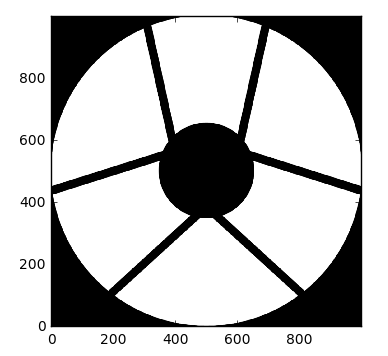

In [65]:
plt.imshow(wfirst_ref_telap)

## Force mirror symmetry

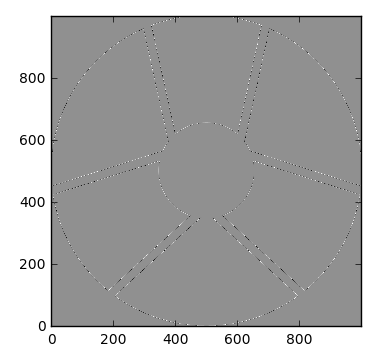

In [66]:
wfirst_symm_telap = np.logical_and(np.round(wfirst_ref_telap).astype(int), np.round(wfirst_ref_telap[:,::-1]).astype(int))
plt.imshow(wfirst_symm_telap - wfirst_ref_telap)

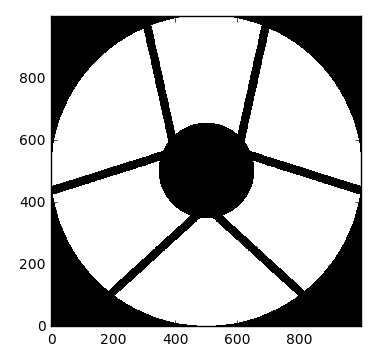

In [67]:
plt.imshow(wfirst_symm_telap)

## Downsample to scale of optimization

In [68]:
wfirst_binned_telap = skimage.transform.resize(wfirst_symm_telap, (2*N, 2*N), order=1)

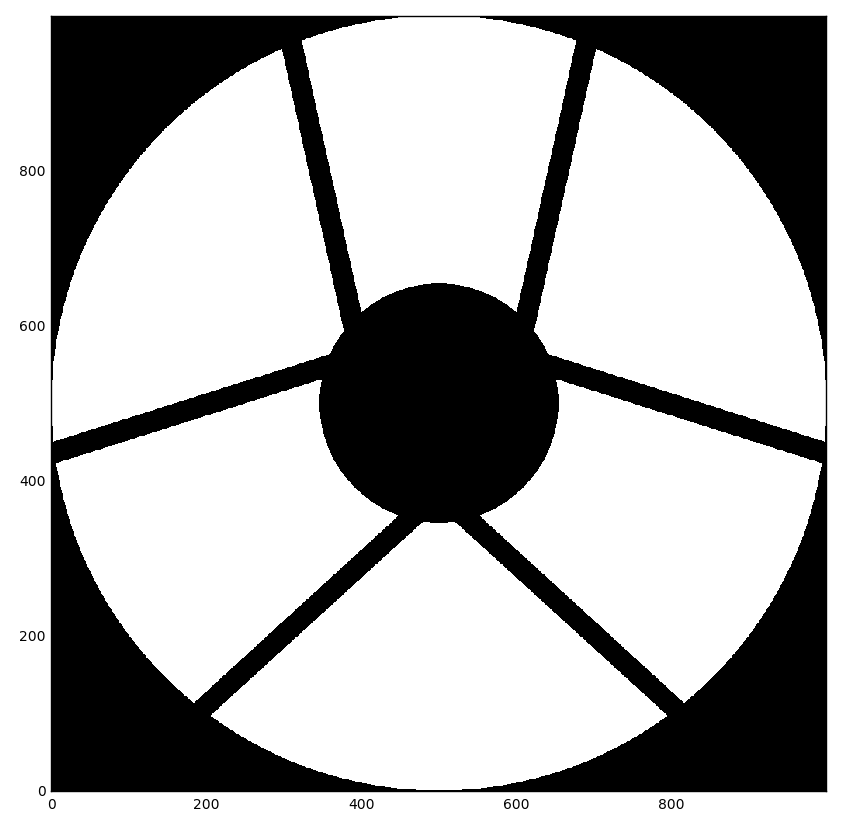

In [69]:
plt.figure(figsize=(10,10))
#plt.imshow(wfirst_binned_telap)
plt.imshow(np.round(wfirst_binned_telap))

## Crop to right half

In [70]:
wfirst_binned_crop = wfirst_binned_telap[:, N:]
print(wfirst_binned_crop.shape)

(1000, 500)


## Form new file name and write 

In [71]:
telap_bin_dat_fname_tail = "TelAp_half_wfirstCycle5_N{:04d}.dat".format(N)
telap_bin_dat_fname = os.path.join(new_telap_dir, telap_bin_dat_fname_tail)

In [72]:
if not os.path.exists(telap_bin_dat_fname) or overwrite is True:
    np.savetxt(telap_bin_dat_fname, wfirst_binned_crop, fmt='%.6f', delimiter=" ")
    print("Wrote binned, cropped telescope aperture array to {0:s}".format(telap_bin_dat_fname))
else:
    print("Telescope aperture array {0:s} already exists, will not overwrite".format(telap_bin_dat_fname))

Wrote binned, cropped telescope aperture array to /astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/TelAp/TelAp_half_wfirstCycle5_N0500.dat


In [73]:
os.listdir(new_telap_dir)

['TelAp_half_wfirstCobs31sthick000_N0125.dat',
 'TelAp_half_wfirstCobs31sthick000_N0128.dat',
 'TelAp_half_wfirstCobs31sthick000_N0250.dat',
 'TelAp_half_wfirstCobs31sthick130_N0125.dat',
 'TelAp_half_wfirstCobs31sthick130_N0128.dat',
 'TelAp_half_wfirstCobs31sthick130_N0250.dat',
 'TelAp_half_wfirstCobs31sthick200_N0125.dat',
 'TelAp_half_wfirstCobs31sthick200_N0128.dat',
 'TelAp_half_wfirstCobs31sthick200_N0250.dat',
 'TelAp_half_wfirstCobs31sthick260_N0125.dat',
 'TelAp_half_wfirstCobs31sthick260_N0128.dat',
 'TelAp_half_wfirstCycle5_N0128.dat',
 'TelAp_half_wfirstCobs31sthick260_N0250.dat',
 'TelAp_half_wfirstCycle5_N0500.dat']